![](https://i.typlog.com/tanxy/8331661530_1720295.jpg)

In [2]:
import scipy.io as sio
import numpy as np
from sklearn import preprocessing
import torch
import torch.nn as nn
import  math
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import logging

In [3]:
# Spectral Residual Learning 模块的输入
class SPCModuleIN(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(SPCModuleIN, self).__init__()
                
        self.s1 = nn.Conv3d(in_channels, out_channels, kernel_size=(7,1,1), stride=(2,1,1), bias=False)
        #self.bn = nn.BatchNorm3d(out_channels)

    def forward(self, input):
        
        input = input.unsqueeze(1)
        
        out = self.s1(input)
        
        return out.squeeze(1) 

In [4]:
# Spectral Residual Leaning 部分
class ResSPC(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(ResSPC, self).__init__()
                
        self.spc1 = nn.Sequential(nn.Conv3d(in_channels, in_channels, kernel_size=(7,1,1), padding=(3,0,0), bias=False),
                                    nn.LeakyReLU(inplace=True),
                                    nn.BatchNorm3d(in_channels),)
        
        self.spc2 = nn.Sequential(nn.Conv3d(in_channels, in_channels, kernel_size=(7,1,1), padding=(3,0,0), bias=False),
                                    nn.LeakyReLU(inplace=True),)
        
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, input):
                
        out = self.spc1(input)
        out = self.bn2(self.spc2(out))
        
        return F.leaky_relu(out + input)

In [5]:
# Spatial Residual Learning 输入部分
class SPAModuleIN(nn.Module):
    def __init__(self, in_channels, out_channels, k=97, bias=True):
        super(SPAModuleIN, self).__init__()
                
        # print('k=',k)
        self.s1 = nn.Conv3d(in_channels, out_channels, kernel_size=(k,3,3), bias=False)
        #self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, input):
                
        # print(input.size())
        out = self.s1(input)
        out = out.squeeze(2)
        # print(out.size)
        
        return out

In [6]:
# Spatial Residual Learning 部分
class ResSPA(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(ResSPA, self).__init__()
                
        self.spa1 = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
                                    nn.LeakyReLU(inplace=True),
                                    nn.BatchNorm2d(in_channels),)
        
        self.spa2 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                                    nn.LeakyReLU(inplace=True),)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
                
        out = self.spa1(input)
        out = self.bn2(self.spa2(out))
        
        return F.leaky_relu(out + input)

In [7]:
# 整个 SSRN 的网络
# 由 SPCModuleIN + ResSPC + SPAModuleI + ResSPA 组成
class SSRN(nn.Module):
    def __init__(self, num_classes=9, k=97):
        super(SSRN, self).__init__()
        
        # 第一层输入，经过第一个卷积层
        self.layer1 = SPCModuleIN(1, 24)
        #self.bn1 = nn.BatchNorm3d(28)
        
        # 第二层，经过第一个光谱卷积块
        self.layer2 = ResSPC(24,24)
        
        # 第三层进入第二个光谱卷积块
        self.layer3 = ResSPC(24,24)
        
        # 第四层，经过空间残差块的输入部分的第一个卷积层
        self.layer4 = SPAModuleIN(24, 24, k=k)
        
        # 
        self.bn4 = nn.BatchNorm2d(24)
        
        self.layer5 = ResSPA(24, 24)
        self.layer6 = ResSPA(24, 24)

        self.fc = nn.Linear(24, num_classes)

    def forward(self, x):

        x = F.leaky_relu(self.layer1(x)) #self.bn1(F.leaky_relu(self.layer1(x)))
#         print(x.shape)
        #print(x.size())
        x = self.layer2(x)
#         print(x.shape)
        x = self.layer3(x)
#         print(x.shape)
        #x = self.layer31(x)

        x = self.bn4(F.leaky_relu(self.layer4(x)))
#         print(x.shape)
        x = self.layer5(x)
#         print(x.shape)
        x = self.layer6(x)
#         print(x.shape)

        x = F.avg_pool2d(x, x.size()[-1])
#         print(x.shape)
        x = self.fc(x.squeeze())
#         print(x.shape)
        
        return x

In [8]:
# 测试一下定义的 SSRN 网络通不通 (batch_size, frames, height, width, channels)
x = torch.randn(1, 200, 7, 7)
net = SSRN(num_classes=16, k=97)
print(net)
y = net(x)
print(y.shape)

SSRN(
  (layer1): SPCModuleIN(
    (s1): Conv3d(1, 24, kernel_size=(7, 1, 1), stride=(2, 1, 1), bias=False)
  )
  (layer2): ResSPC(
    (spc1): Sequential(
      (0): Conv3d(24, 24, kernel_size=(7, 1, 1), stride=(1, 1, 1), padding=(3, 0, 0), bias=False)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (spc2): Sequential(
      (0): Conv3d(24, 24, kernel_size=(7, 1, 1), stride=(1, 1, 1), padding=(3, 0, 0), bias=False)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (bn2): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): ResSPC(
    (spc1): Sequential(
      (0): Conv3d(24, 24, kernel_size=(7, 1, 1), stride=(1, 1, 1), padding=(3, 0, 0), bias=False)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (spc2): Sequent

In [9]:
# 一些预处理函数
def indexToAssignment(index_, pad_length, Row, Col):
    new_assign = {}
    for counter, value in enumerate(index_):
        assign_0 = value // Col + pad_length
        assign_1 = value % Col + pad_length
        new_assign[counter] = [assign_0, assign_1]
    return new_assign

def assignmentToIndex(assign_0, assign_1, Row, Col):
    new_index = assign_0 * Col + assign_1
    return new_index

def selectNeighboringPatch(matrix, ex_len, pos_row, pos_col):
    # print(matrix.shape)
    selected_rows = matrix[:,range(pos_row-ex_len,pos_row+ex_len+1), :]
    selected_patch = selected_rows[:, :, range(pos_col-ex_len, pos_col+ex_len+1)]
    return selected_patch

def sampling(proptionVal, groundTruth):              #divide dataset into train and test datasets
    labels_loc = {}
    train = {}
    test = {}
    m = max(groundTruth)
    for i in range(m):
        indices = [j for j, x in enumerate(groundTruth.ravel().tolist()) if x == i + 1]
        np.random.shuffle(indices)
        labels_loc[i] = indices
        nb_val = int(proptionVal * len(indices))
        train[i] = indices[:-nb_val]
        test[i] = indices[-nb_val:]
    whole_indices = []
    train_indices = []
    test_indices = []
    for i in range(m):
        whole_indices += labels_loc[i]
        train_indices += train[i]
        test_indices += test[i]
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    return whole_indices, train_indices, test_indices



sample_200 = [2, 27, 19, 4, 9, 14, 2, 10, 3, 24, 41, 14, 4, 18, 7, 2]
rsample_200 = [1, 28, 16, 5, 9, 14, 1, 9, 1, 19, 47, 12, 4, 24, 8, 2]

def rsampling(groundTruth, sample_num = sample_200, rsample_num = rsample_200):              #divide dataset into train and test datasets
    labels_loc = {}
    labeled = {}
    train2 = {}
    val = {}
    test = {}
    m = np.max(groundTruth)
    for i in range(m):
        indices = [j for j, x in enumerate(groundTruth.ravel().tolist()) if x == i + 1]
        np.random.shuffle(indices)
        labels_loc[i] = indices
        labeled[i] = indices[:sample_num[i]]
        train2[i] = indices[sample_num[i]:sample_num[i]+rsample_num[i]]
        val[i] =  indices[-(sample_num[i]+rsample_num[i]):]
        test[i] = indices[sample_num[i]+rsample_num[i]:-(sample_num[i]+rsample_num[i])]
    whole_indices = []
    labeled_indices = []
    train2_indices = []
    val_indices = []
    test_indices = []
    for i in range(m):
        whole_indices += labels_loc[i]
        labeled_indices += labeled[i]
        train2_indices += train2[i]
        val_indices += val[i]
        test_indices += test[i]
        np.random.shuffle(labeled_indices)
        np.random.shuffle(train2_indices)        
        np.random.shuffle(val_indices)        
        np.random.shuffle(test_indices)
    return whole_indices, labeled_indices, train2_indices, val_indices, test_indices


def zeroPadding_3D(old_matrix, pad_length, pad_depth = 0):
    new_matrix = np.lib.pad(old_matrix, ((pad_depth, pad_depth), (pad_length, pad_length), (pad_length, pad_length)), 'constant', constant_values=0)
    return new_matrix

### 预处理

In [10]:
# 读取 Indian Pines 数据集
mat_data = sio.loadmat('../data/Indian_pines_corrected.mat')
data_IN = mat_data['indian_pines_corrected']
mat_gt = sio.loadmat('../data/Indian_pines_gt.mat')
gt_IN = mat_gt['indian_pines_gt']
# print(data_IN.shape, gt_IN.shape) → (145, 145, 200) (145, 145)

In [11]:
# Input dataset configuration to generate 103×7×7 HSI samples
new_gt_IN = gt_IN
# the number of land-cover categories in Indian Pines
nb_classes = 16

INPUT_DIMENSION_CONV = 200
INPUT_DIMENSION = 200

# 20%:10%:70% data for training, validation and testing

TOTAL_SIZE = 10249 # Indian Pines 的有效像素是 10249

TRAIN_SIZE = 200
DEV_SIZE = 200
VAL_SIZE = 400
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE - DEV_SIZE - VAL_SIZE # 10249-200-200-400
print('TEST_SIZE=', TEST_SIZE) # TEST_SIZE= 9449

# Indian Pines 数据集的有效光谱通道数
img_channels = 200
PATCH_LENGTH = 4

TEST_SIZE= 9449


In [12]:
# 进行了减去均值除以方差的预处理
MAX = data_IN.max()
data_IN = np.transpose(data_IN, (2,0,1))

data_IN = data_IN - np.mean(data_IN, axis=(1,2), keepdims=True)
data_IN = data_IN / MAX

In [13]:
# np.prod 返回指定轴上的乘积，不指定轴默认是所有元素的乘积
# 这里其实就是将 data_IN.shape=(145, 145, 200) reshap 为 (200, 145×145)，即将前两个维度堆叠
# 还有就是将 data_IN.shape=(145, 145) reshape 为 (21025, )，也是将前两个维度堆叠
data = data_IN.reshape(np.prod(data_IN.shape[:1]),np.prod(data_IN.shape[1:]))
print('----- Some Shapes For details ----')
print('data.shape =', data.shape)
gt = new_gt_IN.reshape(np.prod(new_gt_IN.shape[:2]),)
print('gt.shape =', gt.shape)

whole_data = data.reshape(data_IN.shape[0], data_IN.shape[1],data_IN.shape[2])
print('whole_data.shape =', whole_data.shape)
#whole_data = whole_data - np.mean(whole_data, axis=(1,2), keepdims=True)
# 对 whole_data 进行 PATCH_LENGTH = 4 的填充，其实就是 145 × 145 的 size 每边都增加 4，最后就是 145 + 4 + 4 = 153
padded_data = zeroPadding_3D(whole_data, PATCH_LENGTH)
print('padded_data.shape =', padded_data.shape)

#CATEGORY = 9

train_data = np.zeros((TRAIN_SIZE, INPUT_DIMENSION_CONV, 2*PATCH_LENGTH + 1, 2*PATCH_LENGTH + 1))
print('train_data.shape =', train_data.shape)
test_data = np.zeros((TEST_SIZE, INPUT_DIMENSION_CONV, 2*PATCH_LENGTH + 1, 2*PATCH_LENGTH + 1))
print('test_data.shape =', test_data.shape)
all_data = np.zeros((TOTAL_SIZE, INPUT_DIMENSION_CONV, 2*PATCH_LENGTH + 1, 2*PATCH_LENGTH + 1))
print('all_data.shape =', all_data.shape)


all_indices, train_indices, dev_indices, val_indices, test_indices = rsampling(gt)

y_train = gt[train_indices] - 1
y_test = gt[test_indices] - 1
y_all = gt[all_indices] - 1

train_assign = indexToAssignment(train_indices, PATCH_LENGTH, whole_data.shape[1], whole_data.shape[2])
for i in range(len(train_assign)):
    train_data[i] = selectNeighboringPatch(padded_data, PATCH_LENGTH, train_assign[i][0], train_assign[i][1])
    
test_assign = indexToAssignment(test_indices, PATCH_LENGTH, whole_data.shape[1], whole_data.shape[2])
for i in range(len(test_assign)):
    test_data[i] = selectNeighboringPatch(padded_data, PATCH_LENGTH, test_assign[i][0], test_assign[i][1])
        
all_assign = indexToAssignment(all_indices, PATCH_LENGTH, whole_data.shape[1], whole_data.shape[2])
for i in range(len(all_assign)):
    all_data[i] = selectNeighboringPatch(padded_data, PATCH_LENGTH, all_assign[i][0], all_assign[i][1])

----- Some Shapes For details ----
data.shape = (200, 21025)
gt.shape = (21025,)
whole_data.shape = (200, 145, 145)
padded_data.shape = (200, 153, 153)
train_data.shape = (200, 200, 9, 9)
test_data.shape = (9449, 200, 9, 9)
all_data.shape = (10249, 200, 9, 9)


In [14]:
np.prod([[1, 2], [3, 4]], axis=0)

array([3, 8])

In [15]:
import torch
from torch.utils import data

class HSIDataset(data.Dataset):
    def __init__(self, list_IDs, samples, labels):
        
        self.list_IDs = list_IDs
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = self.samples[ID]
        y = self.labels[ID]

        return X, y

In [16]:
# CUDA for PyTorch
# 选择 GPU 进行训练
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parameters
params = {'batch_size': 50,
          'shuffle': True,
          'num_workers': 8}

# Generators
training_set = HSIDataset(range(len(train_indices)), train_data, y_train)
training_generator = data.DataLoader(training_set, **params)

validation_set = HSIDataset(range(len(test_indices)), test_data, y_test)
validation_generator = data.DataLoader(validation_set, **params)

all_set = HSIDataset(range(len(all_indices)), all_data, y_all)
all_generator = data.DataLoader(all_set, **params)


trainloader = torch.utils.data.DataLoader(training_set, batch_size=50, shuffle=True, num_workers=8)

validationloader = torch.utils.data.DataLoader(validation_set, batch_size=50, shuffle=False, num_workers=8)

allloader = torch.utils.data.DataLoader(all_set, batch_size=50, shuffle=False, num_workers=8)


In [17]:
# 实例化网络，准备放到 GPU 上训练
net = SSRN(num_classes=16, k=97)
net.to(device)

import torch
import torch.optim as optim
# 引入时间模块格式化时间生成唯一训练文件
import time
unique_time = time.strftime("%Y%m%d-%H%M%S")

criterion = nn.CrossEntropyLoss()
#optimizer = optim.RMSprop(net.parameters())
# 论文中使用的是 RMSprop 优化器，但是最后作者还是使用了 Adam，估计优化效果更好吧
optimizer = optim.Adam(net.parameters(), lr=0.002)

best_pred = 0
#SAVE_PATH3 = './saved_models/ssnet_best3_up_seed' + str(args.seed) + '.pth' 
SSRN_TRAIN_SAVE_PATH = 'SSRN-Train-' + unique_time + '.pth' 
#torch.save(net.state_dict(), SAVE_PATH)

for epoch in range(200):  # loop over the dataset multiple times
    
    running_loss = 0.0
    #iters = len(trainloader)
    net = net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 4 == 3:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 4))
            running_loss = 0.0
    #schedular.step()
    
    correct = 0
    total = 0
    net = net.eval()
    counter = 0 
    with torch.no_grad():
        for data in validationloader:
#             if counter <= 10:
#                 counter += 1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()

    new_pred = correct / total
    print('Accuracy of the network on the validation set: %.5f %%' % (
        100 * new_pred))
    
    if new_pred > best_pred:
        logging.info('new_pred %f', new_pred)
        logging.info('best_pred %f', best_pred)
        torch.save(net.state_dict(), SSRN_TRAIN_SAVE_PATH)
        best_pred=new_pred
        
print('Finished Training')

[1,     4] loss: 2.7162
Accuracy of the network on the validation set: 24.11895 %
[2,     4] loss: 2.0227
Accuracy of the network on the validation set: 24.11895 %
[3,     4] loss: 1.7701
Accuracy of the network on the validation set: 0.12700 %
[4,     4] loss: 1.5836
Accuracy of the network on the validation set: 5.72547 %
[5,     4] loss: 1.4111
Accuracy of the network on the validation set: 9.37665 %
[6,     4] loss: 1.3106
Accuracy of the network on the validation set: 9.37665 %
[7,     4] loss: 1.2268
Accuracy of the network on the validation set: 9.37665 %
[8,     4] loss: 1.0714
Accuracy of the network on the validation set: 8.04318 %
[9,     4] loss: 0.9874
Accuracy of the network on the validation set: 8.04318 %
[10,     4] loss: 0.9272
Accuracy of the network on the validation set: 10.06456 %
[11,     4] loss: 0.8138
Accuracy of the network on the validation set: 8.04318 %
[12,     4] loss: 0.7358
Accuracy of the network on the validation set: 8.04318 %
[13,     4] loss: 0.69

Accuracy of the network on the validation set: 90.26352 %
[101,     4] loss: 0.0108
Accuracy of the network on the validation set: 90.55985 %
[102,     4] loss: 0.0090
Accuracy of the network on the validation set: 90.53868 %
[103,     4] loss: 0.0105
Accuracy of the network on the validation set: 90.29527 %
[104,     4] loss: 0.0091
Accuracy of the network on the validation set: 90.07302 %
[105,     4] loss: 0.0109
Accuracy of the network on the validation set: 90.03069 %
[106,     4] loss: 0.0081
Accuracy of the network on the validation set: 90.15769 %
[107,     4] loss: 0.0094
Accuracy of the network on the validation set: 90.30585 %
[108,     4] loss: 0.0056
Accuracy of the network on the validation set: 90.35877 %
[109,     4] loss: 0.0073
Accuracy of the network on the validation set: 90.39052 %
[110,     4] loss: 0.0060
Accuracy of the network on the validation set: 90.46460 %
[111,     4] loss: 0.0071
Accuracy of the network on the validation set: 90.60218 %
[112,     4] loss:

[198,     4] loss: 0.0022
Accuracy of the network on the validation set: 90.49635 %
[199,     4] loss: 0.0026
Accuracy of the network on the validation set: 90.25294 %
[200,     4] loss: 0.0024
Accuracy of the network on the validation set: 90.20002 %
Finished Training


In [18]:
## Validation Stage Functions
def cal_results(matrix):
    shape = np.shape(matrix)
    number = 0
    sum = 0
    AA = np.zeros([shape[0]], dtype=np.float)
    for i in range(shape[0]):
        number += matrix[i, i]
        AA[i] = matrix[i, i] / np.sum(matrix[i, :])
        sum += np.sum(matrix[i, :]) * np.sum(matrix[:, i])
    OA = number / np.sum(matrix)
    AA_mean = np.mean(AA)
    pe = sum / (np.sum(matrix) ** 2)
    Kappa = (OA - pe) / (1 - pe)
    return OA, AA_mean, Kappa, AA


def predVisIN(indices, pred, size1, size2):
    
    if pred.ndim > 1:
        pred = np.ravel(pred)
    
    x = np.zeros(size1*size2)
    x[indices] = pred
    
    y = np.ones((x.shape[0], 3))

    for index, item in enumerate(x):
        if item == 0:
            y[index] = np.array([230, 230, 230]) / 255.  # np.array([255, 255, 255]) / 255.
        if item == 1:
            y[index] = np.array([255, 0, 0]) / 255.
        if item == 2:
            y[index] = np.array([0, 255, 0]) / 255.
        if item == 3:
            y[index] = np.array([0, 0, 255]) / 255.
        if item == 4:
            y[index] = np.array([255, 255, 0]) / 255.
        if item == 5:
            y[index] = np.array([0, 255, 255]) / 255.
        if item == 6:
            y[index] = np.array([255, 0, 255]) / 255.
        if item == 7:
            y[index] = np.array([192, 192, 192]) / 255.
        if item == 8:
            y[index] = np.array([128, 128, 128]) / 255.
        if item == 9:
            y[index] = np.array([128, 0, 0]) / 255.
        if item == 10:  
            y[index] = np.array([128, 128, 0]) / 255.
        if item == 11:
            y[index] = np.array([0, 128, 0]) / 255.
        if item == 12:
            y[index] = np.array([128, 0, 128]) / 255.
        if item == 13:
            y[index] = np.array([0, 128, 128]) / 255.
        if item == 14:
            y[index] = np.array([0, 0, 128]) / 255.
        if item == 15:
            y[index] = np.array([255, 165, 0]) / 255.
        if item == 16:
            y[index] = np.array([255, 215, 0]) / 255.
    
    y_rgb = np.reshape(y, (size1, size2, 3))
    
    return y_rgb

In [19]:
# Validation Stage 

from sklearn import metrics, preprocessing

trained_net = SSRN(num_classes=16, k=97)

trained_net.load_state_dict(torch.load(SSRN_TRAIN_SAVE_PATH))
trained_net.eval()
trained_net = trained_net.cuda()

label_val = []
pred_val = []

with torch.no_grad():
    for data in validationloader:
        images, labels = data
        #label_val = torch.stack([label_val.type_as(labels), labels])
        label_val.append(labels)
        
        images, labels = images.to(device), labels.to(device)
        outputs = trained_net(images.float())
        _, predicted = torch.max(outputs.data, 1)
        #pred_val = torch.stack([pred_val.type_as(predicted), predicted])
        pred_val.append(predicted)
        
label_val_cpu = [x.cpu() for x in label_val]
pred_val_cpu = [x.cpu() for x in pred_val]

label_cat = np.concatenate(label_val_cpu)
pred_cat = np.concatenate(pred_val_cpu)

matrix = metrics.confusion_matrix(label_cat, pred_cat)

OA, AA_mean, Kappa, AA = cal_results(matrix)

print('OA, AA_Mean, Kappa: %f, %f, %f, ', OA, AA_mean, Kappa)
print(str(("AA for each class: ", AA)))

OA, AA_Mean, Kappa: %f, %f, %f,  0.9139591491163086 0.932226390035374 0.9019106981267497
('AA for each class: ', array([0.975     , 0.90743551, 0.88289474, 0.88127854, 0.9082774 ,
       0.99703264, 1.        , 0.98863636, 1.        , 0.88148984,
       0.89863975, 0.84473198, 1.        , 0.9703641 , 0.80337079,
       0.97647059]))


/tmp/ipykernel_5205/1516455691.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AA = np.zeros([shape[0]], dtype=np.float)


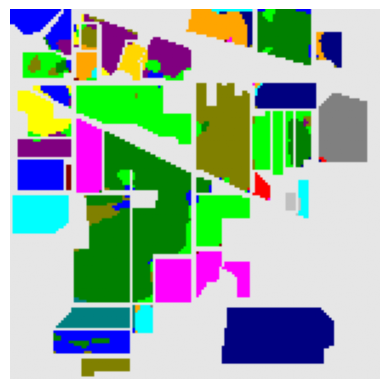

In [21]:
# generate classification maps

import matplotlib.pyplot as plt

all_pred = []

with torch.no_grad():
    for data in allloader:
        images, _ = data
        images, _ = images.to(device), labels.to(device)
        outputs = trained_net(images.float())
        _, predicted = torch.max(outputs.data, 1)
        all_pred.append(predicted)

all_pred = torch.cat(all_pred)
all_pred = all_pred.cpu().numpy() + 1

y_pred = predVisIN(all_indices, all_pred, 145, 145)


#plt.plot(x, y)
plt.imshow(y_pred)
plt.axis('off')
fig_path = 'SSRN-Train-' + unique_time + '.png'
plt.savefig(fig_path, bbox_inches=0)
#plt.savefig(fig_path, bbox_inches='tight')